In [52]:
import pandas as pd
import csv
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Analysis and Pre-processing

In [3]:
df = pd.read_csv("PrePostQuestions.csv")
df.head()

,asin,question,item_name,hours_diff,label
0,B017PICGL0,Are boots cold reliable?,"Reebok Work Men's Zigkick RB7005 Work Shoe, Br...",-1.0,Pre
1,B01HI8YEZS,is the main body rubber or plastic?,"3C-Aone Galaxy S5 Case,Mangix Built-in Glass L...",21.0,Pre
2,B07GZ1LF4R,Do you know the thread pitch/count for the tang?,"ColdLand |14.00"" Hand Forged Damascus Steel Bl...",166.0,Post
3,B07BMNPRFN,The item ordered came tarnished and my son nee...,BEICHUANG Beidou 7 Stars Big Dipper Star Penda...,116.0,Post
4,B075QQKFK3,"""I purchased these and now they look weird wit...",Alla Lighting H8 H11 LED Bulbs Xtreme Super Br...,1021.0,Post


In [4]:
df.groupby("asin")['asin'].count()

asin
0006446469    1
0303532572    1
0439499852    1
0528960911    1
0545703212    1
             ..
B088C1Y5K6    1
B088C5SJLK    1
B088CXT3T3    1
B088F53RSB    1
B088FLBQ97    1
Name: asin, Length: 199884, dtype: int64

In [5]:
df.groupby("label")['hours_diff'].mean()

label
Post    2352.330545
Pre     -207.547994
Name: hours_diff, dtype: float64

In [6]:
# Convert hrs to days
df['days_diff'] = df['hours_diff'] // 24
# write case for -1
# df['days_diff'] = 
df.head()

,asin,question,item_name,hours_diff,label,days_diff
0,B017PICGL0,Are boots cold reliable?,"Reebok Work Men's Zigkick RB7005 Work Shoe, Br...",-1.0,Pre,-1.0
1,B01HI8YEZS,is the main body rubber or plastic?,"3C-Aone Galaxy S5 Case,Mangix Built-in Glass L...",21.0,Pre,0.0
2,B07GZ1LF4R,Do you know the thread pitch/count for the tang?,"ColdLand |14.00"" Hand Forged Damascus Steel Bl...",166.0,Post,6.0
3,B07BMNPRFN,The item ordered came tarnished and my son nee...,BEICHUANG Beidou 7 Stars Big Dipper Star Penda...,116.0,Post,4.0
4,B075QQKFK3,"""I purchased these and now they look weird wit...",Alla Lighting H8 H11 LED Bulbs Xtreme Super Br...,1021.0,Post,42.0


In [7]:
# Rows where item_name is empty
df[df['item_name'].isnull() == True]

# Fill it with no item
df['item_name'].fillna("No Item", inplace=True)

In [8]:
df[df['item_name'].isnull() == True]

,asin,question,item_name,hours_diff,label,days_diff


In [13]:
def process_text(text):
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text
    word_tokens = word_tokenize(text)
    
    # Remove stopwords and punctuations, and perform lemmatization excluding words ending with -ing
    filtered_text = [lemmatizer.lemmatize(word.translate(translator).lower()) if not word.lower().endswith('ing') else word.translate(translator).lower() for word in word_tokens if word.lower() not in stop_words]
    
    return ' '.join(filtered_text)

In [18]:
df['question'] = df['question'].apply(process_text)
df['item_name'] = df['item_name'].apply(process_text)

In [25]:
df.head()

,asin,question,item_name,hours_diff,label,days_diff
0,B017PICGL0,boot cold reliable,reebok work men s zigkick rb7005 work shoe br...,-1.0,1,-1.0
1,B01HI8YEZS,main body rubber plastic,3caone galaxy s5 case mangix builtin glass lu...,21.0,1,0.0
2,B07GZ1LF4R,know thread pitchcount tang,coldland 1400 hand forged damascus steel blan...,166.0,0,6.0
3,B07BMNPRFN,item ordered came tarnished son needed wednesd...,beichuang beidou 7 star big dipper star pendan...,116.0,0,4.0
4,B075QQKFK3,purchased look weird stock headlight headlig...,alla lighting h8 h11 led bulb xtreme super bri...,1021.0,0,42.0


## Data Vectorization

In [20]:
# Value counts 
df['label'].value_counts()

label
Pre     134215
Post     98277
Name: count, dtype: int64

In [24]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [48]:
# Split data into features (X) and labels (y)
X_text = df[['question', 'item_name']]
X_numeric = df[['hours_diff']]
y = df['label']

# Split data into training and testing sets
X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)


In [49]:
# Text vectorization
text_vectorizer = TfidfVectorizer()
X_text_train_tfidf = text_vectorizer.fit_transform(X_text_train['question'] + ' ' + X_text_train['item_name'])
X_text_test_tfidf = text_vectorizer.transform(X_text_test['question'] + ' ' + X_text_test['item_name'])

# Combine text and numeric features
X_train = hstack([X_text_train_tfidf, X_numeric_train])
X_test = hstack([X_text_test_tfidf, X_numeric_test])

## Data Modeling 

Predictig whether the question is a pre purchase question or post purchase question

In [50]:
# Model training
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Model prediction
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


In [51]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19628
           1       1.00      0.99      0.99     26871

    accuracy                           0.99     46499
   macro avg       0.99      0.99      0.99     46499
weighted avg       0.99      0.99      0.99     46499



In [54]:
y_prob = classifier.predict_proba(X_test)[:, 1]

Matplotlib is building the font cache; this may take a moment.


Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1 Score: 0.99
Mean Squared Error: 0.01
ROC AUC Score: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19628
           1       1.00      0.99      0.99     26871

    accuracy                           0.99     46499
   macro avg       0.99      0.99      0.99     46499
weighted avg       0.99      0.99      0.99     46499

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19628
           1       1.00      0.99      0.99     26871

    accuracy                           0.99     46499
   macro avg       0.99      0.99      0.99     46499
weighted avg       0.99      0.99      0.99     46499



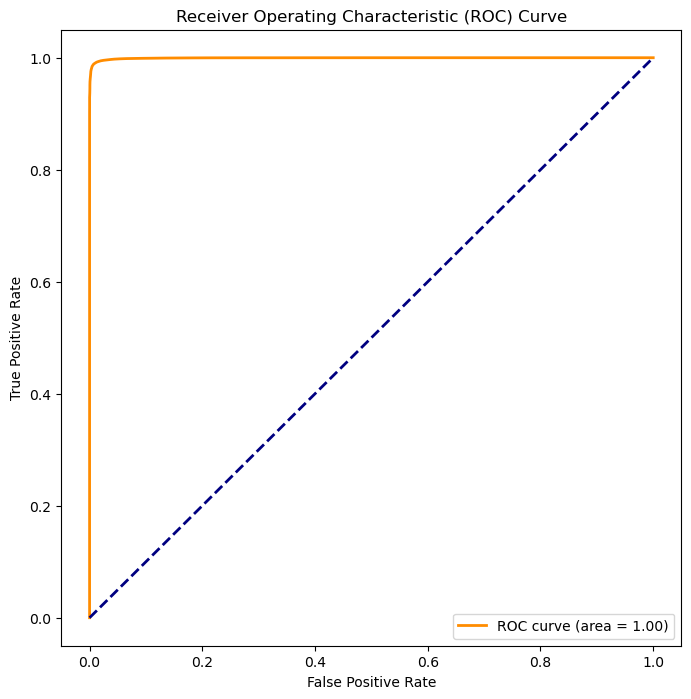

In [56]:
import matplotlib.pyplot as plt
# Calculate and print various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
